In [22]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx as nx
import time
import matplotlib.pyplot as plt
import pickle
import numpy as np
from seirsplus.utilities import load_model, save_model, convert_percentage_to_scale
# from seirsplus.networks import prune_graph_per_age
plt.rcParams["figure.figsize"] = (12, 6)
import pandas as pd
import os
from scipy.interpolate import interp1d


In [23]:
vacc_data = pd.read_csv("../israel_data/vaccination_data_for_simulation.csv")
hos_data = pd.read_csv("../israel_data/hospitalizations_data.csv")

In [24]:
def get_cmap(n=20, map_str= 'hsv'):
    cmap = plt.get_cmap(map_str)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [25]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [26]:
hos_data['date'] =  pd.to_datetime(hos_data['date'], format='%Y-%m-%d')
hos_data['days_from'] = (hos_data['date'] - pd.to_datetime("2020-11-10", format='%Y-%m-%d')).dt.days

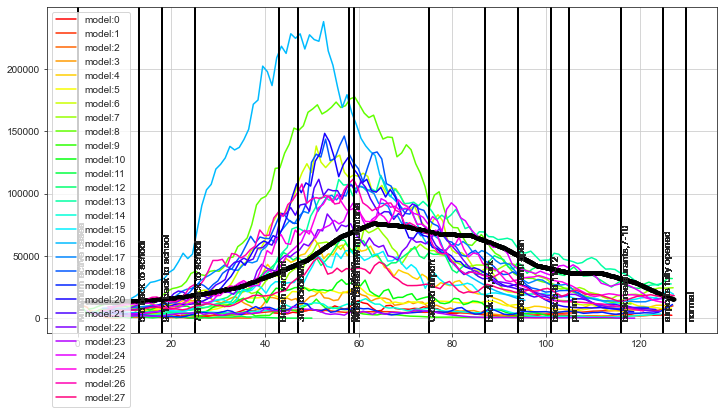

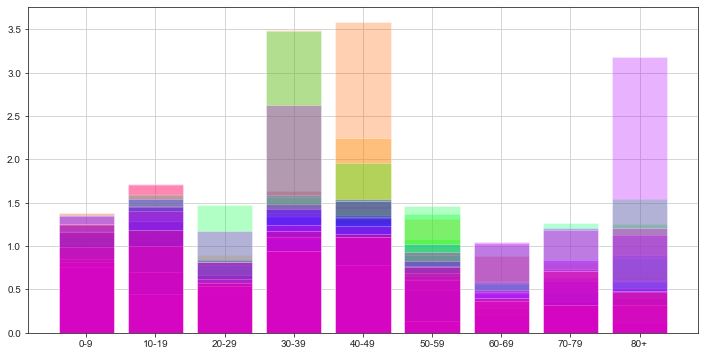

<Figure size 864x432 with 0 Axes>

In [30]:
colors = get_cmap(30)
fig, ax = plt.subplots(1, 1)
fig1, ax1 = plt.subplots(1, 1)
times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = numpy.load('old_files/g_third_lockdown/time_3rd_wave.npy')
active_cases = numpy.load('old_files/g_third_lockdown/active_cases_3rd_wave.npy')



subfolders = [f.path for f in os.scandir("old_files/g_third_lockdown/test_coeffs") if f.is_dir()]
data = {'model': [], 'input_config': [], 'relevant_data': []}
relevant_keys = ['airport', 'two_grades', 'pre_school', 'restaurants', 'work', 'starting_prec', 'holiday', 'quarantine_per', 'normal']
plt.figure()
for i, s in enumerate(subfolders):
    max_time = 130
    data['model'].append(load_model(f"{s}/model_out"))
    with open(f"{s}/input_config.pickle", 'rb') as handle:
        input_data = pickle.load(handle)
    relevant_input = [input_data[k] for k in relevant_keys]
    data['input_config'].append(input_data)
    
    time_ind = np.where(data['model'][i].tseries<=max_time)[0]
    
    
    model_data = (((data['model'][i].numI_sym+data['model'][i].numH)*9e6)/N)[time_ind]
    time_to_plot = data['model'][i].tseries[time_ind]
    
    smooth_model = moving_average(model_data, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    smooth_time = moving_average(time_to_plot, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    
    max_time = np.min([max_time, smooth_time.max()-1])
    min_time = smooth_time.min()+1
    time_scale = np.arange(min_time, max_time, 1)
    f_real_data = interp1d(time, active_cases)
    real_data = f_real_data(time_scale)
    f_model = interp1d(smooth_time, smooth_model)
    model_out = f_model(time_scale)
    ax.plot(time_scale, model_out, color=colors[i], label=f'model:{i}')
    for t, e in zip(times_for_sim, event):
        ax.axvline(int(t), 0, 1, c='k')
        ax.text(int(t)+0.1, 0, str(e), rotation=90)
    ax.plot(time_scale, real_data, '-k', marker='.')
    model_diff = np.linalg.norm((model_out - real_data)/time_to_plot.size)
    relevant_input.append(model_diff)
    relevant_input.append(s)
    
    #                   [0-9,  10-19,20-29,30-39,40-49,50-59,60-69,70-79, 80+]
    age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
    x_k = []
    y_m = []
    for num, key in enumerate(data['model'][i].nodeGroupData.keys()):
        num_nodes = data['model'][i].nodeGroupData[key]['nodes'].size
        per_pop = num_nodes/N
        mean_age = np.mean(data['model'][i].nodeGroupData[key]['numPositive']/(data['model'][i].numPositive+1e-5))
        x_k.append(key)
        y_m.append((mean_age/per_pop).astype(float))
#         print(f"age:{key}, per real:{age_dist[num]}, per sim:{per_pop}")
#         y_m.append((mean_age/age_dist[num]).astype(float))
#     ax1.scatter(x_k,y_m, color=colors[i], marker='x')
    ax1.bar(x_k,y_m, color=colors[i], alpha=0.3)
#     relevant_input.append(np.array(y_m))
    data['relevant_data'].append(relevant_input)
ax.legend()
relevant_keys.append('model_diff')
relevant_keys.append('folder_num')
ax1.grid()
ax.grid()

input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)

In [40]:
# geo_stats[geo_float_columns] = geo_stats[geo_float_columns].astype(float)
for c in input_df.columns:
    if c != "folder_num":
        input_df[c] = input_df[c].astype(float)

In [42]:
input_df.sort_values(by="model_diff", ascending=True)

,airport,two_grades,pre_school,restaurants,work,starting_prec,holiday,quarantine_per,normal,model_diff,folder_num
24,5.0,7.0,11.0,7.0,12.0,78.0,1.0,90.0,17.0,7.186902,old_files/g_third_lockdown/test_coeffs/5
13,0.0,12.0,6.0,6.0,9.0,64.0,0.0,87.0,4.0,11.243763,old_files/g_third_lockdown/test_coeffs/26
25,4.0,9.0,6.0,9.0,8.0,51.0,1.0,90.0,12.0,12.566961,old_files/g_third_lockdown/test_coeffs/14
12,2.0,10.0,13.0,13.0,14.0,79.0,7.0,86.0,11.0,13.539719,old_files/g_third_lockdown/test_coeffs/19
7,4.0,13.0,13.0,6.0,9.0,73.0,0.0,90.0,6.0,13.596322,old_files/g_third_lockdown/test_coeffs/16
17,5.0,7.0,5.0,11.0,9.0,60.0,0.0,91.0,1.0,14.075280,old_files/g_third_lockdown/test_coeffs/23
22,2.0,14.0,5.0,12.0,11.0,75.0,3.0,86.0,2.0,18.950904,old_files/g_third_lockdown/test_coeffs/2
21,1.0,12.0,14.0,8.0,9.0,79.0,8.0,86.0,7.0,19.229248,old_files/g_third_lockdown/test_coeffs/12
26,3.0,12.0,9.0,14.0,8.0,57.0,4.0,89.0,15.0,19.506081,old_files/g_third_lockdown/test_coeffs/22
6,5.0,11.0,8.0,10.0,6.0,77.0,2.0,88.0,4.0,19.706269,old_files/g_third_lockdown/test_coeffs/7


In [8]:
# [(k,data['input_config'][23][k]) for k in data['input_config'][23].keys() if k not in ['beta_values', 'beta_q_values','Q_GLOBALINTXN','P_GLOBALINTXN', 'checkpoint_times']]

In [9]:
data['model'][21].numE[0] * 9*10**6 / N, (data['model'][21].numI_sym[0] * 9*10**6 / N ), 900/990

(8100.0, 9900.0, 0.9090909090909091)

In [10]:
# self.S = 1
# self.E = 2
# self.I_pre = 3
# self.I_sym = 4
# self.I_asym = 5
# self.H = 6
# self.R = 7
# self.F = 8
# self.Q_S = 11
# self.Q_E = 12
# self.Q_pre = 13
# self.Q_sym = 14
# self.Q_asym = 15
# self.Q_R = 17

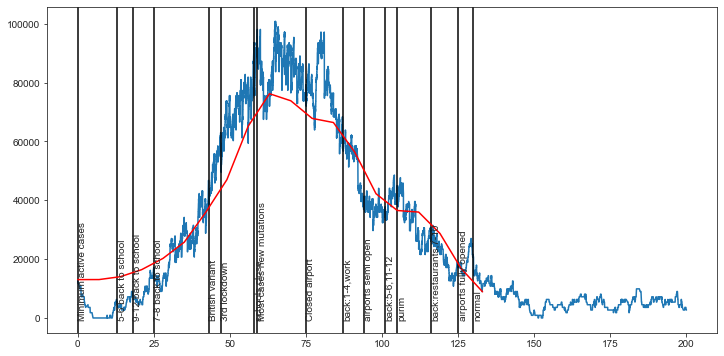

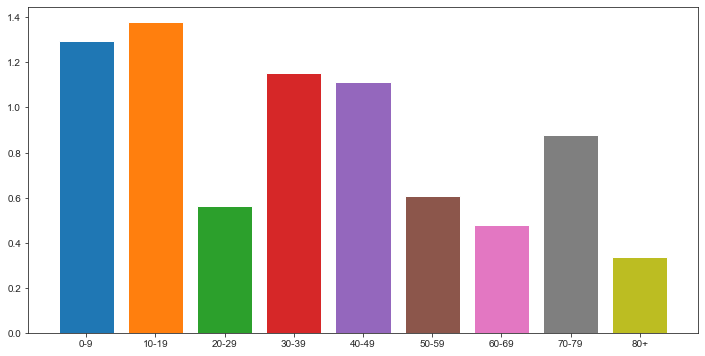

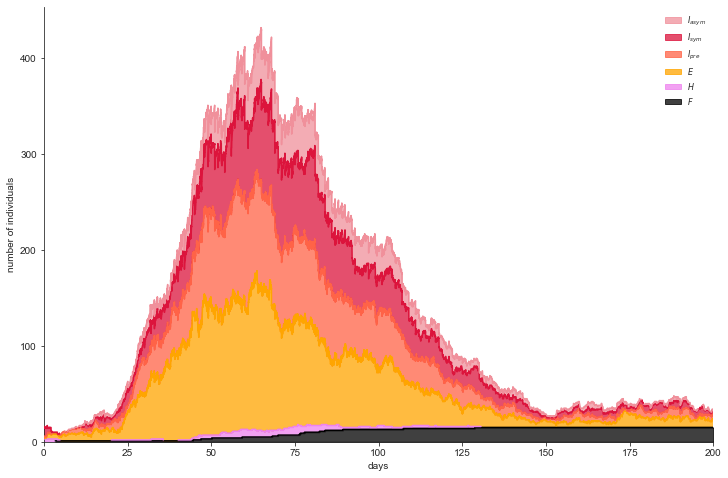

<ipython-input-46-3511f0abcf4e>:32: RuntimeWarning: divide by zero encountered in true_divide
  model_2.numE /model_2.numI_sym


array([0.09090909, 0.1       , 0.        , ..., 2.25      , 3.        ,
       2.66666667])

In [46]:
# time_line = [5, 30, 60, 90, 115, 120, 137, 150, 160]
# events = ['hofesh gadol', 'close <50,20', 'close work', 'schools back', 'full seger', 'maximum-72k',
#          'kindergarden back', 'grades 1-4 back', 'minimum-8000']
model_2 = load_model(f"old_files/g_third_lockdown/test_coeffs/5/model_out")
input_2 = load_model(f"old_files/g_third_lockdown/test_coeffs/5/input_config")

times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
         '7-8 back to school', 'British variant', '3rd lockdown',
         'schools close', 'Most cases new mutations', 'Closed airport',
         'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
         'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

plt.plot(model_2.tseries, ((model_2.numI_sym+model_2.numH)*9e6)/N)
for time, event in zip(times_for_sim, event):
    plt.axvline(int(time), 0, 1, c='k')
    plt.text(int(time)+0.1, 0, str(event), rotation=90)

time = numpy.load('old_files/g_third_lockdown/time_3rd_wave.npy')
active_casese = numpy.load('old_files/g_third_lockdown/active_cases_3rd_wave.npy')
plt.plot(time, active_casese, '-r')
plt.show()

age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
for num, key in enumerate(model_2.nodeGroupData.keys()):
    mean_age = np.mean(model_2.nodeGroupData[key]['numPositive']/(model_2.numPositive+1e-5))
    plt.bar(key,(mean_age/age_dist[num]).astype(float))
plt.show()

fig, ax = model_2.figure_infections(combine_Q_infected=False)
plt.show()
model_2.numE /model_2.numI_sym

In [54]:
input_2['q_global_kids']

0.13

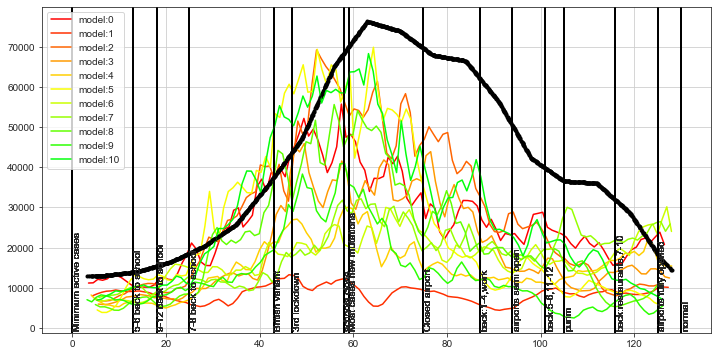

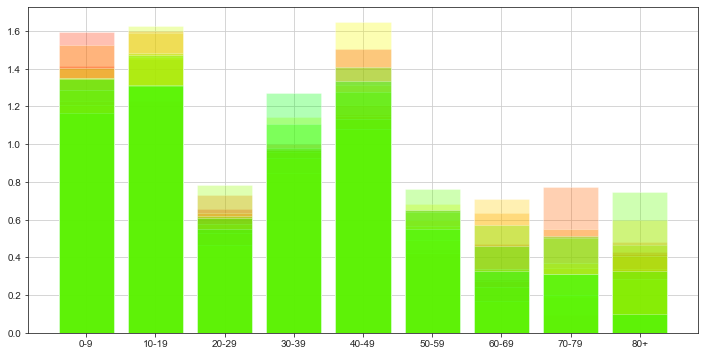

<Figure size 864x432 with 0 Axes>

In [12]:
N = 10000
colors = get_cmap(30)
fig, ax = plt.subplots(1, 1)
fig1, ax1 = plt.subplots(1, 1)
times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = numpy.load('g_third_lockdown/time_3rd_wave.npy')
active_cases = numpy.load('g_third_lockdown/active_cases_3rd_wave.npy')



subfolders = [f.path for f in os.scandir("g_third_lockdown/test_alpha") if f.is_dir()]
data = {'model': [], 'input_config': [], 'relevant_data': []}
relevant_keys = ['airport', 'two_grades', 'pre_school', 'restaurants', 'work', 'starting_prec', 'holiday', 'quarantine_per', 'normal']
plt.figure()
for i, s in enumerate(subfolders):
    max_time = 130
    data['model'].append(load_model(f"{s}/model_out"))
    with open(f"{s}/input_config.pickle", 'rb') as handle:
        input_data = pickle.load(handle)
    relevant_input = [input_data[k] for k in relevant_keys]
    data['input_config'].append(input_data)
    
    time_ind = np.where(data['model'][i].tseries<=max_time)[0]
    
    
    model_data = (((data['model'][i].numI_sym+data['model'][i].numH)*9e6)/N)[time_ind]
    time_to_plot = data['model'][i].tseries[time_ind]
    
    smooth_model = moving_average(model_data, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    smooth_time = moving_average(time_to_plot, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    
    max_time = np.min([max_time, smooth_time.max()-1])
    min_time = smooth_time.min()+1
    time_scale = np.arange(min_time, max_time, 1)
    f_real_data = interp1d(time, active_cases)
    real_data = f_real_data(time_scale)
    f_model = interp1d(smooth_time, smooth_model)
    model_out = f_model(time_scale)
    ax.plot(time_scale, model_out, color=colors[i], label=f'model:{i}')
    for t, e in zip(times_for_sim, event):
        ax.axvline(int(t), 0, 1, c='k')
        ax.text(int(t)+0.1, 0, str(e), rotation=90)
    ax.plot(time_scale, real_data, '-k', marker='.')
    model_diff = np.linalg.norm((model_out - real_data)/time_to_plot.size)
    relevant_input.append(model_diff)
    relevant_input.append(s)
    data['relevant_data'].append(relevant_input)
    #                   [0-9,  10-19,20-29,30-39,40-49,50-59,60-69,70-79, 80+]
    age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
    x_k = []
    y_m = []
    for num, key in enumerate(data['model'][i].nodeGroupData.keys()):
        num_nodes = data['model'][i].nodeGroupData[key]['nodes'].size
        per_pop = num_nodes/N
        mean_age = np.mean(data['model'][i].nodeGroupData[key]['numPositive']/(data['model'][i].numPositive+1e-5))
        x_k.append(key)
        y_m.append((mean_age/per_pop).astype(float))
#         print(f"age:{key}, per real:{age_dist[num]}, per sim:{per_pop}")
#         y_m.append((mean_age/age_dist[num]).astype(float))
#     ax1.scatter(x_k,y_m, color=colors[i], marker='x')
    ax1.bar(x_k,y_m, color=colors[i], alpha=0.3)
ax.legend()
relevant_keys.append('model_diff')
relevant_keys.append('folder_num')
ax1.grid()
ax.grid()

input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)

In [13]:
alone_parma = 0.3
couples_without_kids_param = 0.85
kids_left_house_p = 0.36
old_kids = 0.3
two_kids_young = 0.28
two_kids_old = 0.032

three_kids_young = 0.37
three_kids_old = 0.1

four_kids_young = 0.37
four_kids_old = 0.1

number_of_people_each_household = [1, 4, 4, 2, 2, 3, 3, 4, 5, 8]
households_data = \
    {
    'alone': {0.05 * 0.9: [0, 0, alone_parma/2, alone_parma/2, 0, 0 * (1 - alone_parma) / 8,3 * (1 - alone_parma) / 8,2 * (1 - alone_parma) / 8, 3 * (1 - alone_parma) / 8]},
    'students_app': {0.05 * 0.1: [0, 0.2, 0.8, 0, 0, 0, 0, 0, 0]},
    'soldier': {0.015: [0.0, 0.8, 0.2, 0, 0, 0, 0, 0, 0]},
    'couples_without_kids': {0.935 * 0.28 * 0.25: [0, 0, couples_without_kids_param, 1 - couples_without_kids_param, 0, 0, 0, 0, 0]},
    'couples_kids_left_the_house': {0.935 * 0.28 * 0.75: [0, 0, 0, 0, 0, kids_left_house_p, 16 * (1 - kids_left_house_p) / 30,10 * (1 - kids_left_house_p) / 30, 4 * (1 - kids_left_house_p) / 30]},
    'couples_with_one_young_kid': {0.935 * 0.18 * 0.9: [0.7, 0.3, 0.5, 0.5, 0, 0, 0, 0, 0]},
    'couples_with_one_old_kid': {0.935 * 0.18 * 0.1: [0.0, 1.0, 0.0, old_kids, 1 - old_kids, 0, 0, 0, 0]},
    'couples_with_two_kid': {0.935 * 0.19: [0.5, 0.45, 0.05, two_kids_young, 1 - two_kids_young - two_kids_old, two_kids_old, 0, 0, 0]},
    'couples_with_three_kid': {0.935 * 0.17: [0.5, 0.45, 0.05, three_kids_young, 1 - three_kids_old - three_kids_young, three_kids_old, 0,0, 0]},
    'couples_with_four_kid_pluse': {0.935 * 0.18: [0.5, 0.45, 0.05, three_kids_young, 1 - three_kids_old - three_kids_young, three_kids_old, 0,0, 0]},
}


In [14]:
# list(model_2.X[model_2.nodeGroupData['0-9']['nodes']])

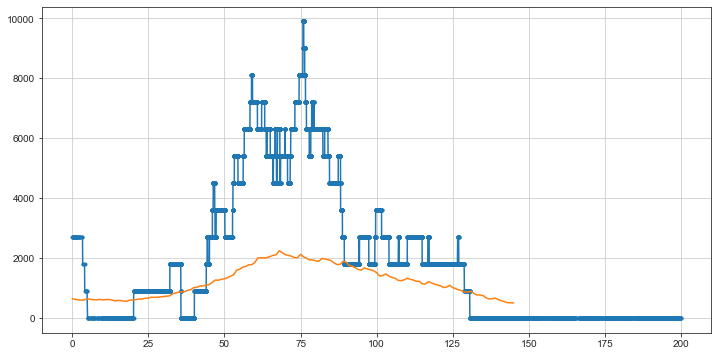

In [18]:
plt.plot(model_2.tseries, model_2.numH * 9*10**6/N, marker='.')
plt.plot(hos_data['days_from'], hos_data['num_hosp'])
plt.grid()

In [101]:
data_pol

,Unnamed: 0,name,description,tagsCsv,time,group
0,0,תחילת הסגר הרשמי,"מגבלת מרחק של 100 מטרים מהבית, פעילויות חיוניו...",NaN,2020-03-19,NaN
1,1,פסח בסגר,פסח בבית (7–16 באפריל) בחברת המשפחה הגרעינית ב...,NaN,2020-04-07,NaN
2,2,מקומות הבילוי והפנאי נפתחים מחדש,"צמצום ההגבלות, פתיחה מחדש של חנויות הרחוב, פתי...",NaN,2020-04-24,NaN
3,3,חזרה חלקית ללימודים,"תלמידי כיתות א'-ג', י""א-י""ב חוזרים ללמוד בקפסו...",NaN,2020-05-03,NaN
4,4,חידוש התפילות והפעילות בבריכות השחייה,"פתיחה של ספריות, מלונות, פארקים ציבוריים, גני ...",NaN,2020-05-04,NaN
5,5,הקניונים נפתחים מחדש,שיעור הבדיקות החיוביות הממוצע ל-7 ימים: 0.75%,NaN,2020-05-07,NaN
6,6,גני הילדים נפתחים מחדש,שיעור הבדיקות החיוביות הממוצע ל-7 ימים: 0.60%,NaN,2020-05-10,NaN
7,7,"חזרה ללימודים, ללא קפסולות","כולם חוזרים ללימודים, הקפסולות מבוטלות (חזרה ל...",NaN,2020-05-17,NaN
8,8,חובת המסכות מבוטלת זמנית בשל שרב כבד,חובת המסכות בחוץ ובכיתות מבוטלת עקב שרב כבד מ-...,NaN,2020-05-19,NaN
9,9,"המסעדות, המועדונים ובתי המלון נפתחים מחדש","פתיחה מחודשת של מסעדות, מועדונים, בתי מלון, בר...",NaN,2020-05-27,NaN
